In [3]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import os
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
from torchvision import transforms
from model import AudioClassifier
from IPython.display import Audio
import torchaudio
from torchaudio.utils import download_asset

c:\Users\Dahong Luo\.conda\envs\pytorch_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
SAMPLE_WAV = download_asset("tutorial-assets/steam-train-whistle-daniel_simon.wav")
SAMPLE_RIR = download_asset("tutorial-assets/Lab41-SRI-VOiCES-rm1-impulse-mc01-stu-clo-8000hz.wav")
SAMPLE_SPEECH = download_asset("tutorial-assets/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042-8000hz.wav")
SAMPLE_NOISE = download_asset("tutorial-assets/Lab41-SRI-VOiCES-rm1-babb-mc01-stu-clo-8000hz.wav")

In [50]:

# Call the function with the path to your image

def preprocess(path,type):
    dir_list = path.split("/")
    file_name = dir_list.pop()
    
    file_name = file_name.split(".")[0]
    
    # Load the audio file
    audio, sr = librosa.load(path)

    # Compute the spectrogram
    spectrogram = librosa.feature.melspectrogram(y=audio, sr=sr)

    # Convert the spectrogram to dB scale
    spectrogram_db = librosa.power_to_db(spectrogram, ref=np.max)

    # Display the spectrogram
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(spectrogram_db, sr=sr)
    plt.savefig(f"datasets/imgs/tmp/{type}/{file_name}.png", bbox_inches='tight', pad_inches=0)
    resize_img(file_name,type)
    plt.close()

def resize_img(file_name,type):
    # Open the image
    image = Image.open(f"datasets/imgs/tmp/{type}/{file_name}.png")

    # Resize the image
    resized_image = image.resize((50, 50))

    # Save the resized image
    resized_image.save(f"datasets/imgs/{type}/resized_{file_name}.png")

In [51]:
def convert_to_tensor(file_path,type):
    
    type_dic = {"angry_sound":0, "Bird":1, "Cats":2, "Dog":3, "guns":4}
    
    dir_list = file_path.split("/")
    file_name = dir_list.pop()
    
    file_name = file_name.split(".")[0]
    
    resized_image = Image.open(f"datasets/imgs/{type}/{file_name}.png")

    # Remove the alpha channel
    resized_image = resized_image.convert("RGB")

    # Apply the ToTensor transformation
    transform = transforms.ToTensor()
    image_tensor = transform(resized_image)

    int_tensor = torch.tensor(type_dic[type])
    # Print the PyTorch matrix
    return (image_tensor, int_tensor)



In [52]:
def parse(type):
    
# Specify the directory path
    directory = f"datasets/sounds/{type}"

    # Get the list of file names in the directory
    file_names = os.listdir(directory)

    # Print the file names

    for file in file_names:
        preprocess("/".join([directory,file]),type)

In [3]:
import torchaudio.functional as F

def apply_rir(path,type):
    file_name = path.split("/").pop().split(".")[0]
    rir_raw, sample_rate = torchaudio.load(SAMPLE_RIR)
    
    rir = rir_raw[:, int(sample_rate * 1.01) : int(sample_rate * 1.3)]
    rir = rir / torch.linalg.vector_norm(rir, ord=2)
    
    
    
    sound, _ = torchaudio.load(path)
    augmented = F.fftconvolve(sound, rir)
    
    torchaudio.save(f"datasets/sounds/{type}/{file_name}_rir.wav", augmented, sample_rate)

In [53]:
import os
names = os.listdir("datasets/imgs")
names.remove("tmp")
print(names)
print(len(names))


['airplane', 'Bird', 'car_horn', 'Cats', 'chirping_birds', 'church_bells', 'cow', 'crow', 'crying_baby', 'Dog', 'engine', 'frog', 'glass_breaking', 'guns', 'helicopter', 'laughing', 'pig', 'rooster', 'siren', 'thunderstorm', 'train']
21


In [7]:
import os

# Specify the directory path
directory = "datasets/sounds/airplane"

# Get the list of file names in the directory
file_names = os.listdir(directory)

# Iterate over the file names
for file_name in file_names:
    # Check if the file name contains "rir"
    if "rir" in file_name:
        # Construct the file path
        file_path = os.path.join(directory, file_name)
        
        # Delete the file
        os.remove(file_path)


In [54]:
for type in names:
    print(type)
    parse(type)
    

airplane
Bird
car_horn
Cats
chirping_birds
church_bells
cow
crow
crying_baby
Dog
engine
frog
glass_breaking
guns
helicopter
laughing
pig
rooster
siren
thunderstorm
train


In [56]:
import shutil
types = names
for type in types:
    if not os.path.exists(f"datasets/chroma_imgs/hz/{type}"):
        os.makedirs(f"datasets/chroma_imgs/hz/{type}")
    if not os.path.exists(f"datasets/chroma_imgs/shift/{type}"):
        os.makedirs(f"datasets/chroma_imgs/shift/{type}")
    
    files = os.listdir(f"datasets/imgs/{type}")
    for file in files:
        if "pitch" in file:
            source_path = f"datasets/imgs/{type}/{file}"
            destination_path = f"datasets/chroma_imgs/hz/{type}/{file}"
            shutil.move(source_path, destination_path)
        elif "chroma" in file:
            source_path = f"datasets/imgs/{type}/{file}"
            destination_path = f"datasets/chroma_imgs/shift/{type}/{file}"
            shutil.move(source_path, destination_path)
        


In [39]:
def apply_codec(waveform, sample_rate, format, encoder=None):
    encoder = torchaudio.io.AudioEffector(format=format, encoder=encoder)
    return encoder.apply(waveform, sample_rate)

In [47]:
def apply_vorbis(path):
    file_name = path.split("/").pop().split(".")[0]
    waveform, sample_rate = torchaudio.load(path, channels_first=False)
    
    vorbis = apply_codec(waveform, sample_rate, format="ogg", encoder="vorbis")
    Audio(vorbis.T,rate = sample_rate)
    
    torchaudio.save(f"datasets/tmp/vorbis/{file_name}_vorbis.wav", vorbis.T, sample_rate)

[Text(0.5, 1.0, 'Mel-frequency spectrogram')]

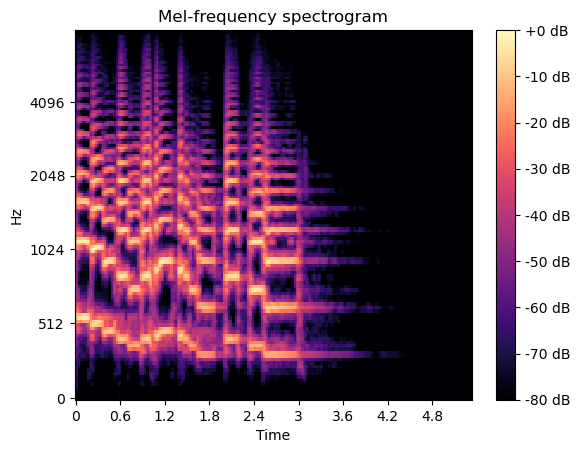

In [15]:
y, sr = librosa.load(librosa.ex('trumpet'))

D = np.abs(librosa.stft(y))**2
S = librosa.feature.melspectrogram(S=D, sr=sr)

fig, ax = plt.subplots()
S_dB = librosa.power_to_db(S, ref=np.max)
img = librosa.display.specshow(S_dB, x_axis='time',
                         y_axis='mel', sr=sr,
                         fmax=8000, ax=ax)
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='Mel-frequency spectrogram')

In [63]:
apply_rir("datasets/sounds/Cats/cat_1.wav")

In [38]:
rir_raw, sample_rate1 = torchaudio.load("datasets/sounds/airplane/1-11687-A-47.wav", channels_first=False)

vorbis = apply_codec(waveform1, sample_rate1, "ogg", encoder = "vorbis")
Audio(vorbis.T, rate=sample_rate1)

# Export audio as WAV file
torchaudio.save("datasets/tmp/output/1-11687-A-47_applied.wav", vorbis.T, sample_rate1)


In [43]:
import os

# Specify the directory path
# Get the list of file names in the directory


for type in names:
    file_names = os.listdir(f"datasets/imgs/{type}")
# Iterate over the file names
    for file_name in file_names:
        # Check if the file name contains "chroma"
        if "chroma" in file_name:
            # Construct the file path
            
            # Delete the file
            os.remove(f"datasets/imgs/{type}/{file_name}")


In [44]:
def apply_chroma_shift(path,type):
    file_name = path.split("/").pop().split(".")[0]
    
    y,sr = librosa.load(path)
    S = np.abs(librosa.stft(y, n_fft=4096))**2
    file_name = path.split("/").pop().split(".")[0]
    waveform, sample_rate = librosa.load(path)
    
    fig, ax = plt.subplots(nrows=1, sharex=True)

    # Display and save the first image
    img = librosa.display.specshow(librosa.amplitude_to_db(S, ref=np.max), y_axis='chroma', x_axis='time', ax=ax)
    ax.axis('off')
    fig.set_size_inches(4, 4)
    plt.savefig(f"datasets/imgs/{type}/{file_name}_chroma.png", bbox_inches='tight', pad_inches=0)
    plt.close()
    
for type in names:
    print(type)
    path = f"datasets/sounds/{type}"
    files = os.listdir(path)
    for file in files:
        if "rir" not in file:
            apply_chroma_shift(f"datasets/sounds/{type}/{file}",type)


airplane
Bird
car_horn
Cats
chirping_birds
church_bells
cow
crow
crying_baby
Dog
engine
frog
glass_breaking
guns
helicopter
laughing
pig
rooster
siren
thunderstorm
train


In [49]:
def apply_chroma_pitch(path,type):
    file_name = path.split("/").pop().split(".")[0]
    
    y,sr = librosa.load(path)
    S = np.abs(librosa.stft(y, n_fft=4096))**2
    chroma = librosa.feature.chroma_stft(S=S, sr=sr)
    file_name = path.split("/").pop().split(".")[0]
    
    fig, ax = plt.subplots(nrows=1, sharex=True)

    # Display and save the first image
    img = librosa.display.specshow(chroma, y_axis='chroma', x_axis='time', ax=ax)
    ax.axis('off')
    fig.set_size_inches(4, 4)
    plt.savefig(f"datasets/imgs/{type}/{file_name}_chroma_pitch.png", bbox_inches='tight', pad_inches=0)
    plt.close()

for type in names:
    print(type)
    path = f"datasets/sounds/{type}"
    files = os.listdir(path)
    for file in files:
        if "rir" not in file and "chroma" not in file:
            apply_chroma_pitch(f"datasets/sounds/{type}/{file}",type)


airplane


c:\Users\Dahong Luo\.conda\envs\pytorch_env\lib\site-packages\librosa\core\pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


Bird
car_horn
Cats
chirping_birds
church_bells
cow
crow
crying_baby
Dog
engine
frog
glass_breaking
guns
helicopter
laughing
pig
rooster
siren
thunderstorm
train


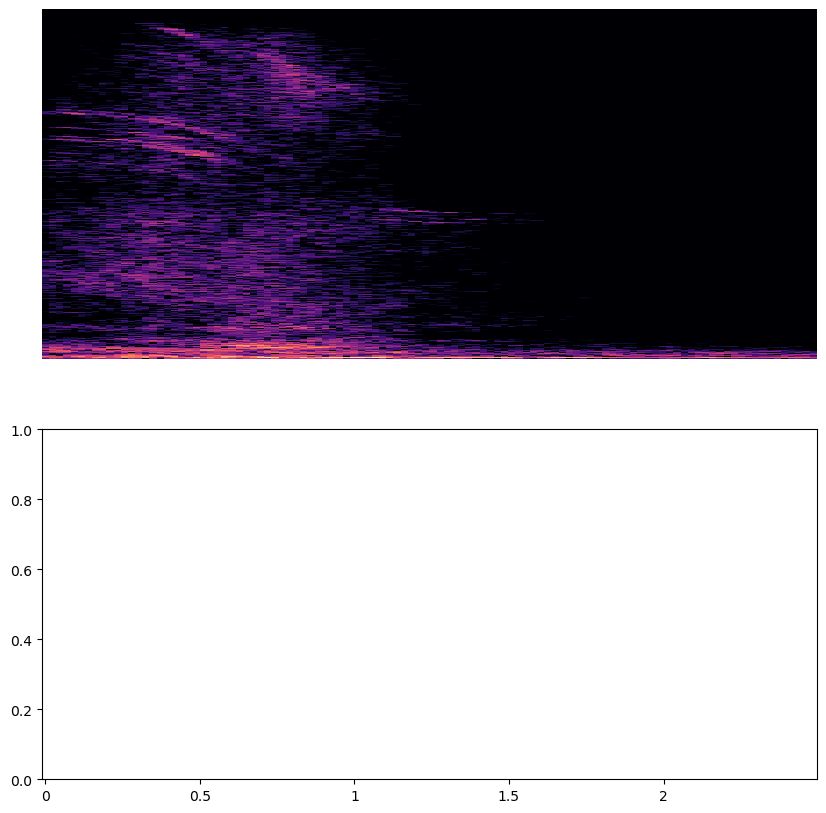

In [30]:
y, sr = librosa.load("datasets/tmp/output/1-11687-A-47_applied.wav")
S = np.abs(librosa.stft(y, n_fft=4096))**2
chroma = librosa.feature.chroma_stft(S=S, sr=sr)

fig, ax = plt.subplots(nrows=2, sharex=True)

# Display and save the first image
img = librosa.display.specshow(librosa.amplitude_to_db(S, ref=np.max), y_axis='chroma', x_axis='time', ax=ax[0])
ax[0].axis('off')
fig.set_size_inches(10, 10)
#plt.savefig('image1.png', bbox_inches='tight', pad_inches=0)
plt.show()
plt.close()

# Display and save the second image
img = librosa.display.specshow(chroma, y_axis='chroma', x_axis='time', ax=ax[1])
ax[1].axis('off')
fig.set_size_inches(1, 1)
#plt.savefig('image2.png', bbox_inches='tight', pad_inches=0)
plt.close()


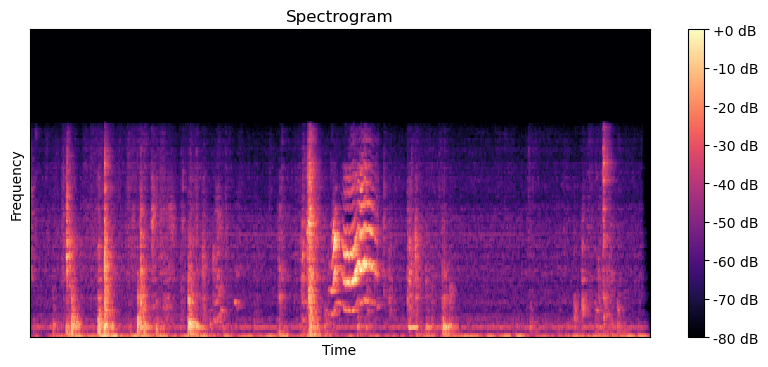

In [64]:
import librosa
import librosa.display
import matplotlib.pyplot as plt

# Load the audio file
audio_path = 'datasets/tmp/rir/cat_1_rir.wav'
audio, sr = librosa.load(audio_path)

# Compute the spectrogram
spectrogram = librosa.feature.melspectrogram(y=audio, sr=sr)

# Convert the spectrogram to dB scale
spectrogram_db = librosa.power_to_db(spectrogram, ref=np.max)

# Display the spectrogram
plt.figure(figsize=(10, 4))
librosa.display.specshow(spectrogram_db, sr=sr)
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.show()

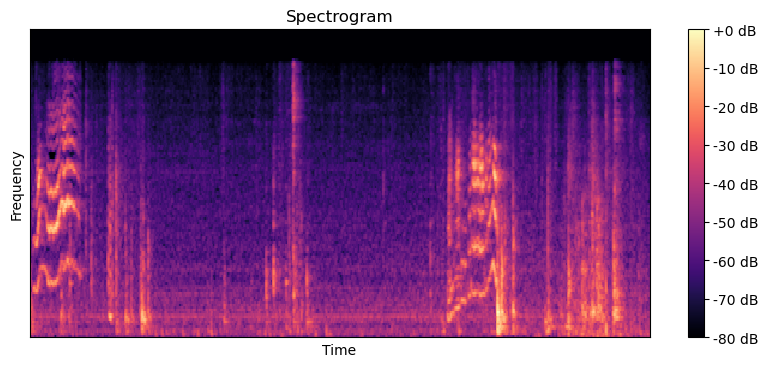

In [65]:

# Load the audio file
audio_path = 'datasets/sounds/Cats/cat_2.wav'
audio, sr = librosa.load(audio_path)

# Compute the spectrogram
spectrogram = librosa.feature.melspectrogram(y=audio, sr=sr)

# Convert the spectrogram to dB scale
spectrogram_db = librosa.power_to_db(spectrogram, ref=np.max)

# Display the spectrogram
plt.figure(figsize=(10, 4))
librosa.display.specshow(spectrogram_db, sr=sr)
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.show()

In [5]:
def load_datda(type_map):
    res = []
    for type in type_map:
        directory = f"datasets/imgs/{type}"
        file_names = os.listdir(directory)
        for file in file_names:
            resized_image = Image.open(f"datasets/imgs/{type}/{file}")
            
            resized_image = resized_image.convert("RGB")

            # Apply the ToTensor transformation
            transform = transforms.ToTensor()
            image_tensor = transform(resized_image)

            target = torch.tensor(type_map[type])
            # Print the PyTorch matrix
            res.append((image_tensor, target))
    
    return res

In [6]:
res = (load_datda({"angry_sound":0, "Bird":1, "Cats":2, "Dog":3, "guns":4}))

In [8]:
print(len(res))

598


In [85]:
print(L)

[(tensor([[[0.0000, 0.0314, 0.3490,  ..., 0.1137, 0.0745, 0.0588],
         [0.0000, 0.1059, 0.6784,  ..., 0.3098, 0.2235, 0.2039],
         [0.0000, 0.0863, 0.6196,  ..., 0.3843, 0.3490, 0.3137],
         ...,
         [0.4706, 0.6000, 0.8980,  ..., 0.8941, 0.8549, 0.7333],
         [0.4549, 0.5765, 0.8941,  ..., 0.8275, 0.8510, 0.7216],
         [0.3569, 0.5529, 0.9098,  ..., 0.7804, 0.7608, 0.6745]],

        [[0.0000, 0.0078, 0.1059,  ..., 0.0314, 0.0235, 0.0235],
         [0.0000, 0.0235, 0.2118,  ..., 0.0706, 0.0627, 0.0667],
         [0.0000, 0.0235, 0.1922,  ..., 0.0980, 0.0863, 0.0745],
         ...,
         [0.1373, 0.1686, 0.4157,  ..., 0.3176, 0.2824, 0.2235],
         [0.1294, 0.1608, 0.4510,  ..., 0.2627, 0.2745, 0.2196],
         [0.0941, 0.1490, 0.4902,  ..., 0.2431, 0.2353, 0.2039]],

        [[0.0039, 0.0863, 0.2980,  ..., 0.2078, 0.1529, 0.1412],
         [0.0000, 0.2196, 0.4667,  ..., 0.4902, 0.4353, 0.4078],
         [0.0000, 0.2000, 0.4549,  ..., 0.5020, 0.4902, 

In [108]:
import torch

loader = torch.utils.data.DataLoader(res, batch_size=32, shuffle=True)

In [109]:
loader

In [123]:
from model import AudioClassifier
model = AudioClassifier(5)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

n_epochs = 10

for epochs in range(n_epochs):
    for inputs, labels in loader:
        if labels[0] == 4:
            continue
        y_pred = model(inputs)
        loss = loss_fn(y_pred, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


In [124]:
torch.save(model.state_dict(), "models/model_2.pth")

In [125]:
# Load the trained model
model = AudioClassifier(5)
model.load_state_dict(torch.load("models/model_1.pth"))

# Set the model to evaluation mode
model.eval()

AudioClassifier(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1))
  (act1): ReLU()
  (drop1): Dropout(p=0.3, inplace=False)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act2): ReLU()
  (pool2): MaxPool2d(kernel_size=(4, 4), stride=(4, 4), padding=0, dilation=1, ceil_mode=False)
  (flat): Flatten(start_dim=1, end_dim=-1)
  (fc3): Linear(in_features=18432, out_features=512, bias=True)
  (act3): ReLU()
  (drop3): Dropout(p=0.5, inplace=False)
  (fc4): Linear(in_features=512, out_features=5, bias=True)
)

In [128]:


# Perform inference on a single input
input_tensor, _ = convert_to_tensor("datasets/imgs/guns/resized_cat_11.png", "Cats")
output = model(input_tensor.unsqueeze(0))

# Get the predicted class
_, predicted_class = torch.max(output, 1)

# Print the predicted class
print(predicted_class.item())


2


(tensor([[[0.0000, 0.0314, 0.3490,  ..., 0.1137, 0.0745, 0.0588],
         [0.0000, 0.1059, 0.6784,  ..., 0.3098, 0.2235, 0.2039],
         [0.0000, 0.0863, 0.6196,  ..., 0.3843, 0.3490, 0.3137],
         ...,
         [0.4706, 0.6000, 0.8980,  ..., 0.8941, 0.8549, 0.7333],
         [0.4549, 0.5765, 0.8941,  ..., 0.8275, 0.8510, 0.7216],
         [0.3569, 0.5529, 0.9098,  ..., 0.7804, 0.7608, 0.6745]],

        [[0.0000, 0.0078, 0.1059,  ..., 0.0314, 0.0235, 0.0235],
         [0.0000, 0.0235, 0.2118,  ..., 0.0706, 0.0627, 0.0667],
         [0.0000, 0.0235, 0.1922,  ..., 0.0980, 0.0863, 0.0745],
         ...,
         [0.1373, 0.1686, 0.4157,  ..., 0.3176, 0.2824, 0.2235],
         [0.1294, 0.1608, 0.4510,  ..., 0.2627, 0.2745, 0.2196],
         [0.0941, 0.1490, 0.4902,  ..., 0.2431, 0.2353, 0.2039]],

        [[0.0039, 0.0863, 0.2980,  ..., 0.2078, 0.1529, 0.1412],
         [0.0000, 0.2196, 0.4667,  ..., 0.4902, 0.4353, 0.4078],
         [0.0000, 0.2000, 0.4549,  ..., 0.5020, 0.4902, 0

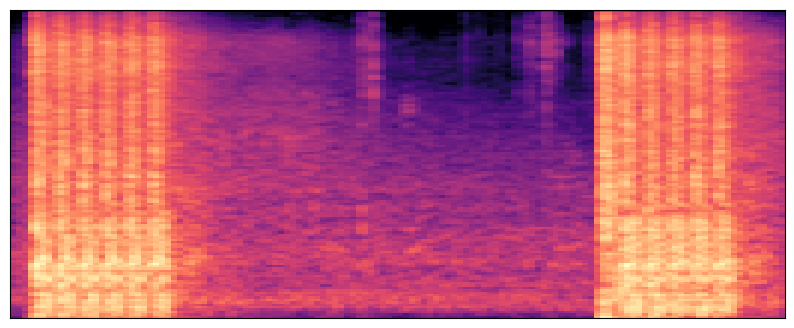

In [60]:
preprocess("datasets/sounds/guns/1 (1).wav")
tup = convert_to_tensor("datasets/imgs/guns/resized_tmp.png")
print(tup)

In [43]:
a,b = (tup,1)

print(b)


1


In [ ]:
import os

# Specify the directory path
directory = "datasets"

# Get the list of file names in the directory
file_names = os.listdir(directory)

# Print the file names
print(file_names)
